### 1. Data Load and Feature Extraction

In [24]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops

def extract_glcm_features(gray_img):
    # Ensure 8-bit grayscale
    if gray_img.max() > 255:
        gray_img = (gray_img / gray_img.max() * 255).astype(np.uint8)
    
    # Reduce levels for smaller GLCM (optional)
    gray_img = (gray_img / 4).astype(np.uint8)  # Now levels=64

    glcm = graycomatrix(gray_img, 
                        distances=[1], 
                        angles=[0], 
                        levels=64, 
                        symmetric=True, 
                        normed=True)
    
    features = {
        'contrast': graycoprops(glcm, 'contrast')[0, 0],
        'homogeneity': graycoprops(glcm, 'homogeneity')[0, 0],
        'energy': graycoprops(glcm, 'energy')[0, 0],
        'correlation': graycoprops(glcm, 'correlation')[0, 0],
    }
    return features

# Set your dataset directory
dataset_path = 'brain_tumor_dataset'

data = []
labels = []

# Loop through subfolders "yes" and "no"
for label_folder in ['yes', 'no']:
    full_folder_path = os.path.join(dataset_path, label_folder)
    for file_name in os.listdir(full_folder_path):
        if file_name.endswith(('.png', '.jpg', '.jpeg')):  # Adjust as needed
            file_path = os.path.join(full_folder_path, file_name)
            
            # Read image in grayscale
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128))
            if img is None:
                continue  # Skip unreadable files
            
            # Extract features
            features = extract_glcm_features(img)
            features['label'] = label_folder  # Add label
            data.append(features)

# Create DataFrame
df = pd.DataFrame(data)
print(df.head())

    contrast  homogeneity    energy  correlation label
0  19.647576     0.534307  0.174363     0.966927   yes
1  57.343627     0.477806  0.145564     0.886962   yes
2  47.934424     0.656069  0.364375     0.856214   yes
3  32.374877     0.397063  0.116515     0.907771   yes
4  54.317667     0.431251  0.082053     0.900337   yes


### 2. Model Comparison and Evaluation Using Multiple Classifiers

In [25]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Create DataFrame
df = pd.DataFrame(data)

# Split into features (X) and labels (y)
X = df.drop('label', axis=1)
y = df['label'].map({'yes': 1, 'no': 0})  # Convert 'yes'/'no' to 1/0

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB()
}

# Store classifier performance metrics
results = []

# Iterate over classifiers, train and evaluate
for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Get accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store results
    report = classification_report(y_test, y_pred, output_dict=True)
    precision = report['accuracy']  # This returns the accuracy
    recall = report['macro avg']['recall']
    f1_score = report['macro avg']['f1-score']

    # Append results to the list
    results.append({
        'Classifier': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by Accuracy in descending order
results_df = results_df.sort_values(by='Accuracy', ascending=False)

results_df


Training SVM...

Training Logistic Regression...

Training Random Forest...

Training K-Nearest Neighbors...

Training Decision Tree...

Training Naive Bayes...


,Classifier,Accuracy,Precision,Recall,F1-Score
0,SVM,0.740741,0.740741,0.740741,0.740741
1,Logistic Regression,0.740741,0.740741,0.740741,0.740385
5,Naive Bayes,0.722222,0.722222,0.722222,0.722127
2,Random Forest,0.703704,0.703704,0.703704,0.703297
4,Decision Tree,0.703704,0.703704,0.703704,0.703297
3,K-Nearest Neighbors,0.685185,0.685185,0.685185,0.685077


### 3. Confusion Matrix Visualization for Classifier Comparison

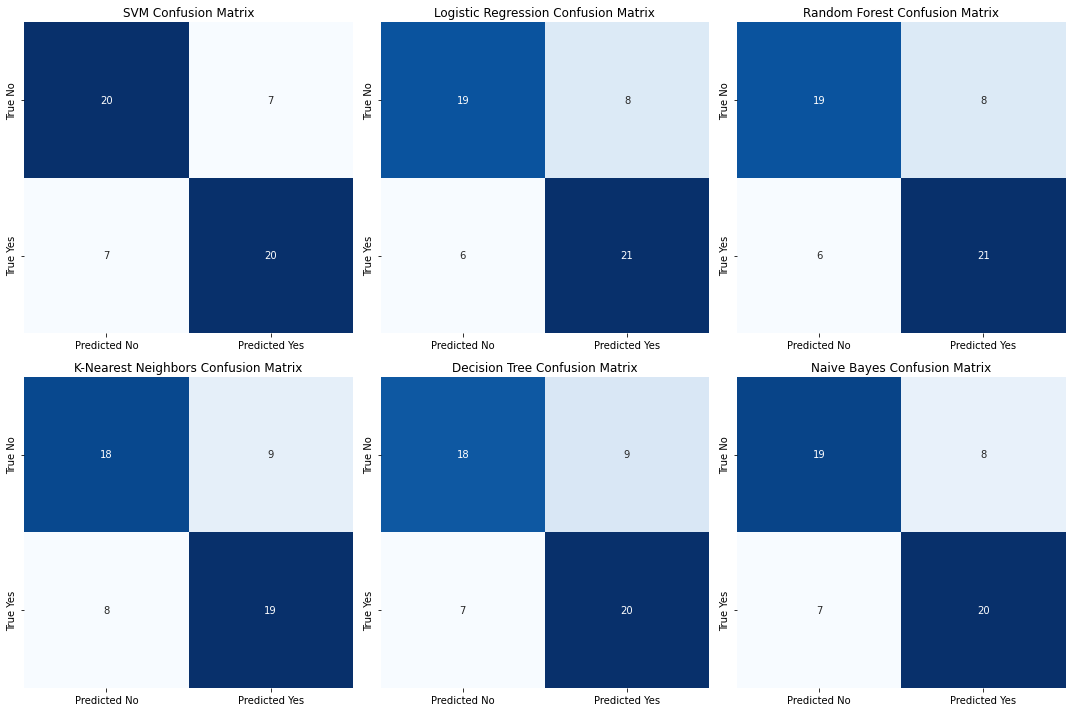

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Initialize classifiers
classifiers = {
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB()
}

# Set up the figure for plotting
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Create a 2x3 grid of subplots
axes = axes.flatten()  # Flatten the axes array to easily index each subplot

# Iterate over classifiers, train, evaluate, and plot confusion matrix
for i, (name, clf) in enumerate(classifiers.items()):
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix using Seaborn's heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Predicted No', 'Predicted Yes'], 
                yticklabels=['True No', 'True Yes'], ax=axes[i])
    
    # Set the title for the subplot
    axes[i].set_title(f'{name} Confusion Matrix')

# Adjust the layout
plt.tight_layout()
plt.savefig('Correlation_Matrix.png',dpi=300)
plt.show()